# Introduction

For starters we will use ten different actors, denoted by different video id:s.


We will apply LOGO CV (Leave One Group Out cross-validation)

We will later have to take into account variables like mode (prosody or vocalization) and intensity (1-4) in the cross validation scheme. 

However for the first run it will be fine to include all without taking such factors into account.



In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy
from dotenv import load_dotenv

# Working dir

In [2]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.sql_handling.execute_sql import execute_sql_pandas

# Paths

In [4]:
load_dotenv()

# path to save figures
output_path = os.getenv("VIDEO_OUT")

# Global configuration path
glob_conf_path = '../global_config.py'

In [5]:
output_path

'/home/tim/work/su-thesis-project/emotional-recognition/files/tests/out/video/'

# Load global variables

In [6]:
exec(open(glob_conf_path).read())

# Select data from DB

We only select data that satisfies following three conditions:

* Success == 1
* Confidence rate >= 0.98
* mix (mixed emotions) = False(0)

We also only select the following six video_ids: 'A101', 'A102', 'A18', 'A200'

In [7]:
AU_COLS = ['AU01_r',
'AU02_r',
'AU04_r',
'AU05_r',
'AU06_r',
'AU07_r',
'AU09_r',
'AU10_r',
'AU12_r',
'AU14_r',
'AU15_r',
'AU17_r',
'AU20_r',
'AU23_r',
'AU25_r',
'AU26_r',
'AU45_r']

In [8]:
#query = """SELECT filename,
#video_id,
#emotion_1,
#emotion_1_id,
#frame,
#success,
#confidence,
#AU01_r,
#AU02_r,
#AU04_r,
#AU05_r,
#AU06_r,
#AU07_r,
#AU09_r,
#AU10_r,
#AU12_r,
#AU14_r,
#AU15_r,
#AU17_r,
#AU20_r,
#AU23_r,
#AU25_r,
#AU26_r,
#AU45_r
#FROM openface
#WHERE mix = 0
#AND (intensity_level = 4 OR emotion_1 = 'neu')
#AND situation = 1 
#AND mode = 'v'
#AND video_id IN ('A101', 'A102', 'A18', 'A200', 'A303', 'A227', 'A21', 'A18');"""
#df, read_duration = execute_sql_pandas(query)

In [9]:
query = """SELECT filename,
video_id,
emotion_1,
emotion_1_id,
frame,
success,
confidence,
AU01_r,
AU02_r,
AU04_r,
AU05_r,
AU06_r,
AU07_r,
AU09_r,
AU10_r,
AU12_r,
AU14_r,
AU15_r,
AU17_r,
AU20_r,
AU23_r,
AU25_r,
AU26_r,
AU45_r
FROM openface
WHERE mix = 0;"""
df, read_duration = execute_sql_pandas(query)

In [10]:
print("query executed in: {} seconds".format(read_duration))

query executed in: 131.045 seconds


In [11]:
df

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A050121-R_awe_p_3,A050121-R,awe,18,1,1,1,0.00,0.00,0.73,...,1.25,1.61,0.05,0.00,1.86,0.04,0.23,0.00,1.53,0.29
1,A050121-R_awe_p_3,A050121-R,awe,18,2,1,1,0.00,0.00,0.66,...,1.27,1.54,0.07,0.00,1.68,0.03,0.23,0.00,1.41,0.13
2,A050121-R_awe_p_3,A050121-R,awe,18,3,1,1,0.00,0.00,0.63,...,1.32,1.52,0.08,0.00,1.57,0.03,0.20,0.00,1.32,0.04
3,A050121-R_awe_p_3,A050121-R,awe,18,4,1,1,0.00,0.00,0.63,...,1.33,1.51,0.10,0.00,1.57,0.01,0.17,0.00,1.33,0.23
4,A050121-R_awe_p_3,A050121-R,awe,18,5,1,1,0.00,0.00,0.69,...,1.33,1.53,0.10,0.04,1.59,0.01,0.11,0.00,1.41,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266563,A91_sad_p_3,A91,sad,6,196,1,1,0.04,0.00,0.00,...,0.64,0.71,0.00,0.00,0.00,0.00,0.00,1.64,0.00,0.03
2266564,A91_sad_p_3,A91,sad,6,197,1,1,0.00,0.00,0.00,...,0.57,0.67,0.00,0.04,0.02,0.00,0.00,1.54,0.00,0.04
2266565,A91_sad_p_3,A91,sad,6,198,1,1,0.00,0.01,0.00,...,0.50,0.64,0.00,0.10,0.02,0.00,0.00,1.44,0.00,0.02
2266566,A91_sad_p_3,A91,sad,6,199,1,1,0.00,0.10,0.00,...,0.50,0.64,0.00,0.17,0.05,0.00,0.00,1.38,0.00,0.02


Total number of instances: 2266568

Number of Instances per File (before data cleaning)
A205_sad_v_3         1549
A205_sad_v_4         1437
A205_fea_v_1         1218
A223_ple_v_4         1216
A205_sad_v_1         1214
                     ... 
A303_hap_v_1           37
A050121-R_exc_p_3      34
A050121-R_fea_p_1      33
A337_cont_v_1          33
A303_tri_v_1           27
Name: filename, Length: 11062, dtype: int64



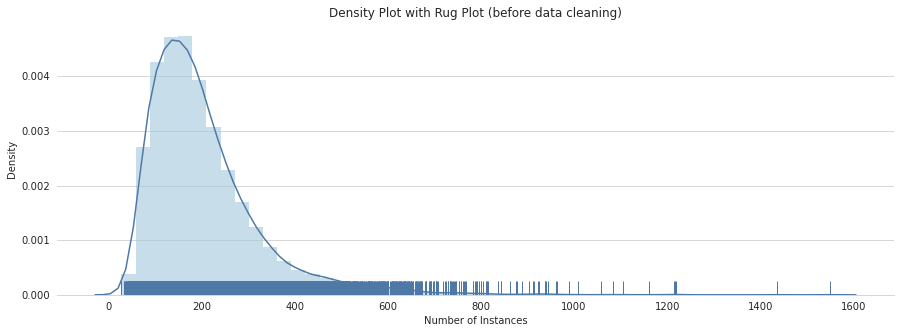


Number of Instances per Video id (before data cleaning)
A55          179899
A223         153763
A205         138796
A102         104285
A220          98338
A64           95564
A67           87523
A26           82101
A221          80275
A101          79726
A72           75630
A207          74833
A218          74039
A327          68931
A74           68177
A103          67451
A200          62877
A91           60390
A334          57489
A65           57067
A75           56230
A227          54594
A323          53944
A18           53269
A201          50629
A303          43081
A332          43056
A21           41127
A337          39395
A34           35888
A050121-R     28201
Name: video_id, dtype: int64


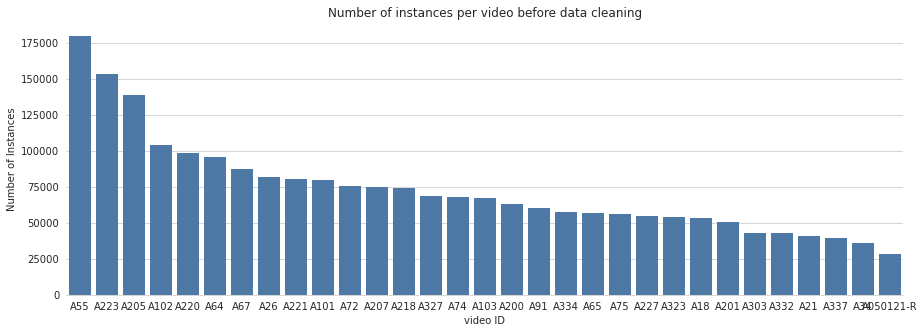


Number of Instances per Emotion (before data cleaning)
conc       60645
dou        60573
sad        59671
nos        59466
awe        58057
pea        57408
sha        56290
anx        56115
gui        55550
mov        55250
emb        55116
conf       53414
reg        53381
sat        53018
bor        52746
env        52044
ple        52040
ins        51670
sex        51261
ele        51239
disa       51220
hop        51151
neu        50846
ang        50781
neg_sur    50699
scha       50067
adm        49998
ten        49629
fea        49375
cont       49314
rej        49268
int        48395
gra        48310
pos_sur    48295
rel        47601
det        47587
pri        47531
disg       46975
dist       46814
exc        46439
sar        45917
amu        45731
hap        45271
tri        44400
Name: emotion_1, dtype: int64


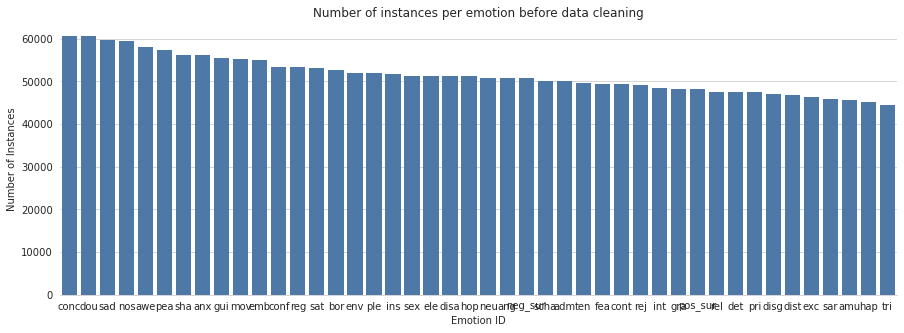


Number of Instances per Success Status (before data cleaning)
1    2257056
0       9512
Name: success, dtype: int64


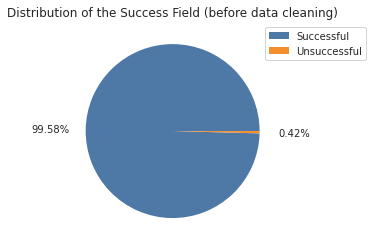


Percentage of Instances per Confidence Rate (before data cleaning)
0    0.00372
1    0.99628
Name: confidence, dtype: float64


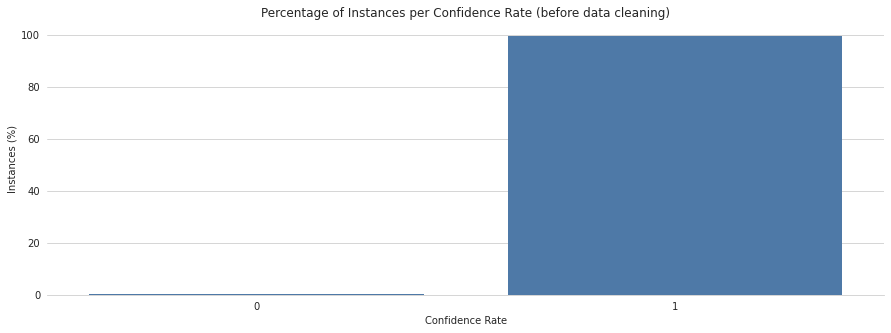

In [12]:
print("Total number of instances: {}".format(len(df)))
print()


print("Number of Instances per File (before data cleaning)")
file_val_counts_original = df["filename"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Video id (before data cleaning)")
video_val_counts_original = df["video_id"].value_counts()
print(video_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(video_val_counts_original.index, video_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per video before data cleaning")
plt.xlabel('video ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (before data cleaning)")
emotion_val_counts_original = df["emotion_1"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion before data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()

print("Number of Instances per Success Status (before data cleaning)")
success_val_counts_original = df["success"].value_counts()
print(success_val_counts_original)
plt.figure()
plt.pie(success_val_counts_original.values, autopct='%1.2f%%', pctdistance= 1.4, colors=palette_def)
plt.legend(['Successful','Unsuccessful'],bbox_to_anchor=(0.9, 1))
plt.savefig(os.path.join(output_path,'charts','report_success_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Distribution of the Success Field (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','success_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

print("Percentage of Instances per Confidence Rate (before data cleaning)")
confidence_val_counts_original = df["confidence"].value_counts(normalize=True).sort_index()
print(confidence_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(confidence_val_counts_original.index, 100*confidence_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.xlabel('Confidence Rate')
plt.ylabel('Instances (%)')
plt.savefig(os.path.join(output_path,'charts','report_confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Percentage of Instances per Confidence Rate (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

In [13]:
print("Number of Instances per video id for every filename")
video_val_counts_original = df[['video_id','filename']].groupby(["video_id"]).filename.nunique().reset_index()
print(video_val_counts_original)
print()

Number of Instances per video id for every filename
     video_id  filename
0   A050121-R       352
1        A101       352
2        A102       352
3        A103       352
4         A18       352
5        A200       340
6        A201       352
7        A205       352
8        A207       352
9         A21       352
10       A218       344
11       A220       352
12       A221       352
13       A223       340
14       A227       352
15        A26       352
16       A303       351
17       A323       352
18       A327       342
19       A332       328
20       A334       342
21       A337       352
22        A34       352
23        A55       620
24        A64       352
25        A65       352
26        A67       328
27        A72       352
28        A74       348
29        A75       339
30        A91       352



## Number of frames for every filename

Number of frames for every filename


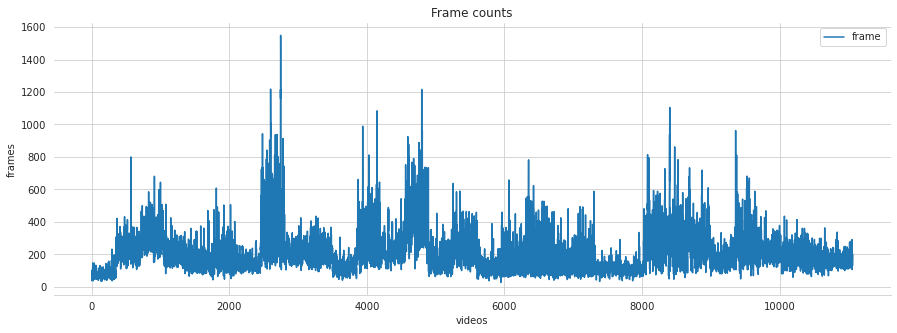

In [14]:
print("Number of frames for every filename")
frame_counts = df[['frame','filename']].groupby(["filename"]).frame.nunique().reset_index()
frame_counts.plot(figsize=(15,5))
plt.title("Frame counts")
plt.xlabel('videos')
plt.ylabel('frames')
plt.show()

## Missing frames grouped by video

In [15]:
def get_unsuccessfull(df):
    ratios = []
    
    # iterate over a df for every filename
    for filename, df_filename in df.groupby('filename'):
        total = df_filename.shape[0]    
        
        # get the sum of all rows with success and greater than 0.98 confidence in df
        successful = (df_filename['success'] == 1).sum()
        confident = (df_filename['confidence'] > 0.98).sum() 

        # calculate ratio between unsuccess or low confidence rows and total number of rows
        success_ratio = successful/total 
        confidence_ratio = confident/total

        if success_ratio < 1 or confidence_ratio < 1:   
            ratios.append({"filename": filename,
                                  "success_ratio": success_ratio,
                                  "confidence_ratio": confidence_ratio})
    # create df from records
    ret_df = pd.DataFrame.from_records(ratios)
    
    # sort values (highest success rate / confident rate first
    ret_df.sort_values(by=['success_ratio', 'confidence_ratio'], inplace = True)
    
    return ret_df

In [16]:
df_ratios = get_unsuccessfull(df)

In [17]:
df_ratios

,filename,success_ratio,confidence_ratio
119,A55_dou_p_4_ver1,0.000000,0.000000
120,A55_dou_p_4_ver2,0.000000,0.000000
166,A55_sat_p_4,0.000000,0.000000
169,A55_scha_v_4_ver1,0.188630,0.217054
288,A75_emb_p_4,0.220779,0.214286
...,...,...,...
300,A75_pea_v_4,1.000000,0.996656
195,A64_gui_v_4,1.000000,0.997167
201,A64_sad_v_4,1.000000,0.997260
161,A55_sad_v_3_ver1,1.000000,0.998004


<Figure size 1080x360 with 0 Axes>

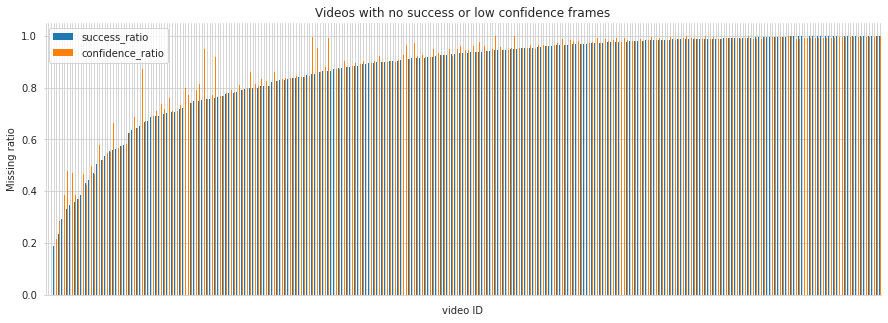

In [18]:
plt.figure(figsize=(15,5))
ax = df_ratios.plot(figsize=(15,5), kind = "bar")
ax.xaxis.set_ticklabels([])

plt.title("Videos with no success or low confidence frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

## Clean the data

Remove all files with too many missing frames

In [19]:
threshold = 0.9

# seems to be some overlapping issue here, look into AND and OR statements

filenames_to_remove = df_ratios[(df_ratios.success_ratio <= threshold) | (df_ratios.confidence_ratio <= threshold)].filename
filenames_to_keep = df_ratios[(df_ratios.success_ratio > threshold) & (df_ratios.confidence_ratio > threshold)].filename
df = df[df.filename.isin(filenames_to_remove) == False]

Inspect result after cleaning

<Figure size 1080x360 with 0 Axes>

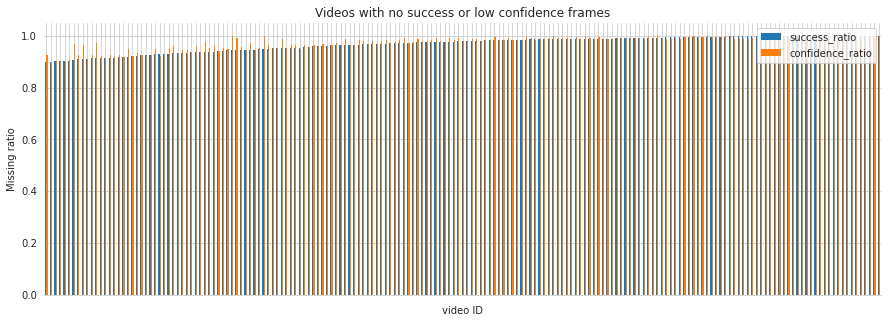

In [20]:
df_new_ratios = get_unsuccessfull(df)

plt.figure(figsize=(15,5))
ax = df_new_ratios.plot(figsize=(15,5), kind = "bar")
ax.xaxis.set_ticklabels([])

plt.title("Videos with no success or low confidence frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

In [21]:
# save an example of a df with missing frames
df_example = df[df['filename'] == filenames_to_keep.iloc[0]]
save_path = os.path.join(output_path, 'success_ratio_90_and_over.csv')
df_example.to_csv(save_path, index=None, header=True)

## Interpolate missing values

In [77]:
df.shape

(2238359, 24)

In [78]:
df.isna().sum().sum()

0

In [79]:
# set the AU value of all rows with bad frames to NaN
for au in AU_COLS:
    df.loc[(df['success'] != 1) | (df['confidence'] != 1), au] = np.NaN

In [80]:
df.isna().sum().sum()

28016

In [81]:
pd.options.mode.chained_assignment = None  # default='warn'

for filename in filenames_to_keep:    
    df_filename = df[df['filename'] ==  filename]
    
    #print("before")
    #print(df.isna().sum().sum())
    
    df_filename[AU_COLS] = df_filename[AU_COLS].interpolate(method="linear")
    
    df[df['filename'] ==  filename] = df_filename
    
    #print("after")
                                                            
    #print(df.isna().sum().sum())    
    

In [82]:
df.isna().sum().sum()

5780

In [83]:
# drop rows that couldn't be interpolated
df = df.dropna()

In [88]:
df.isna().sum().sum()

0

### Plot some examples of interpolated data

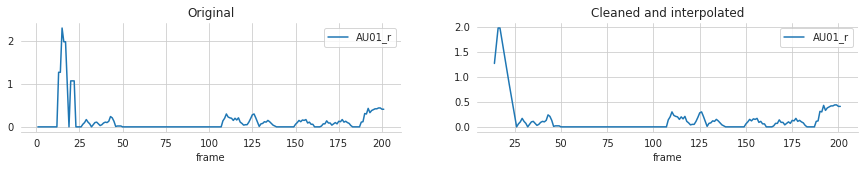

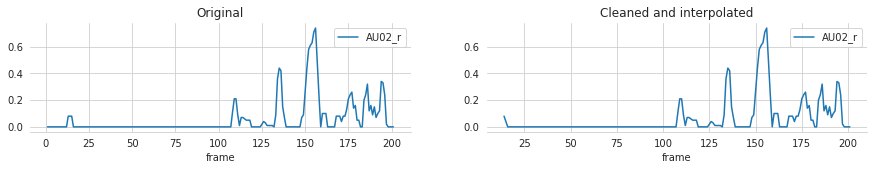

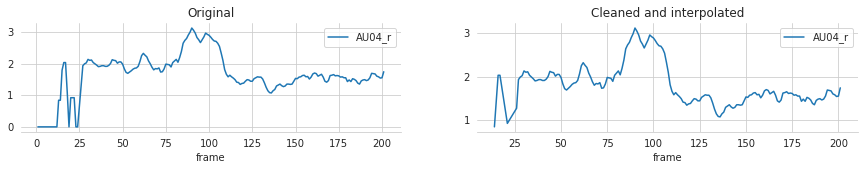

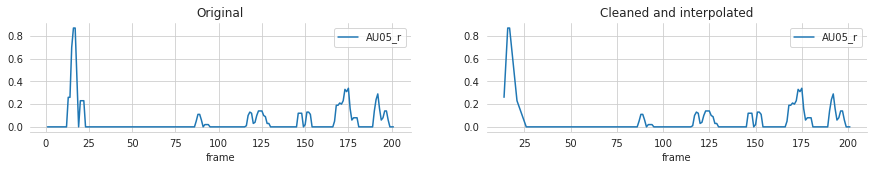

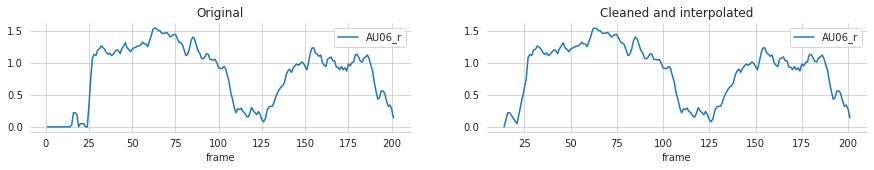

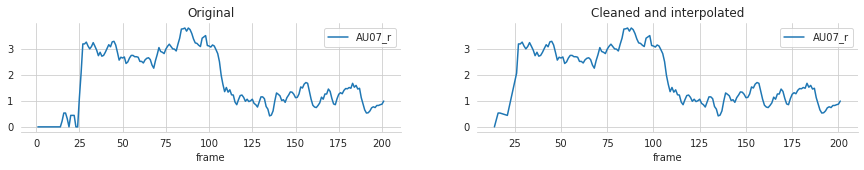

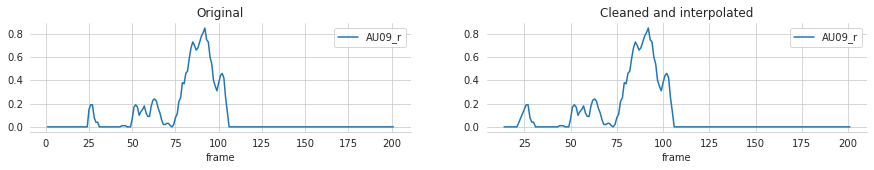

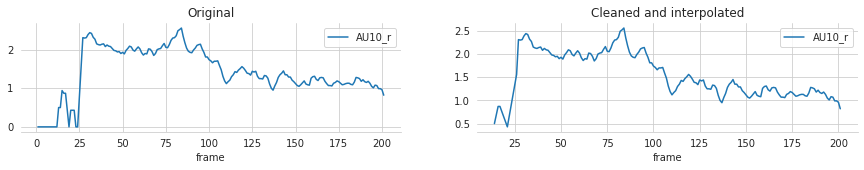

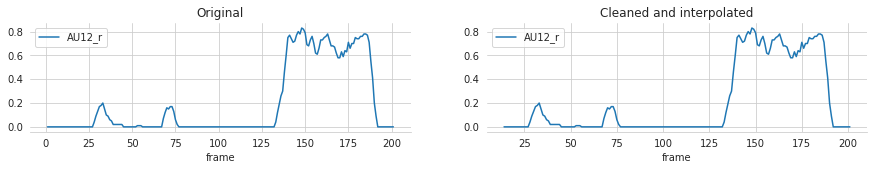

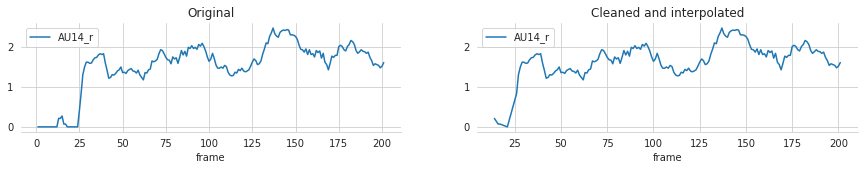

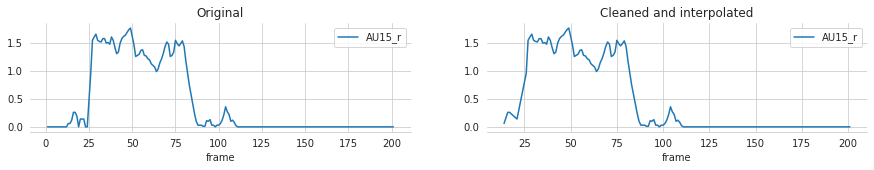

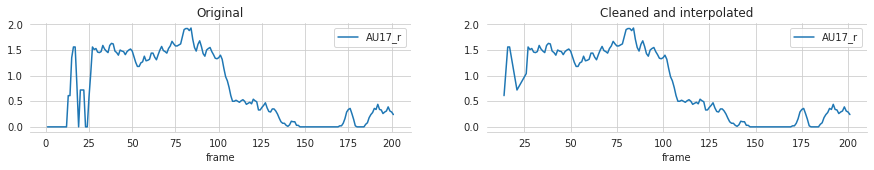

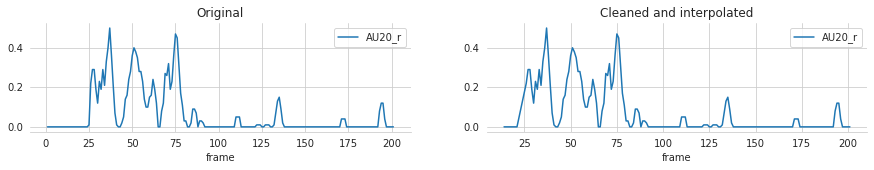

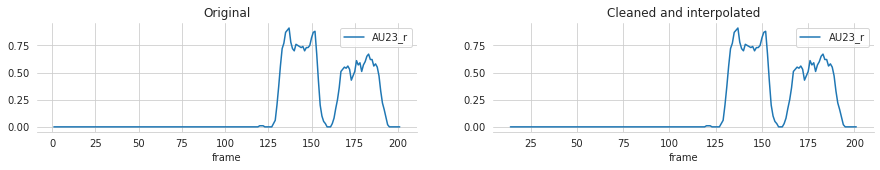

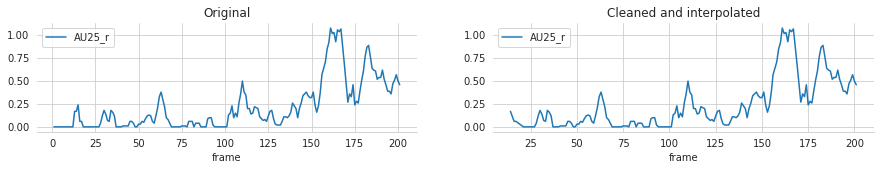

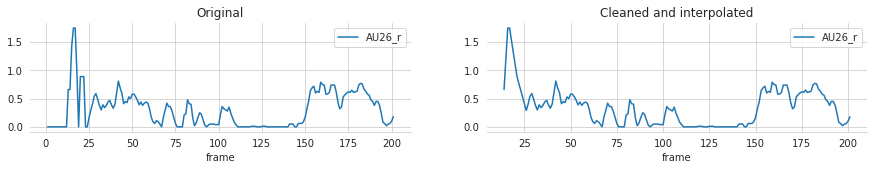

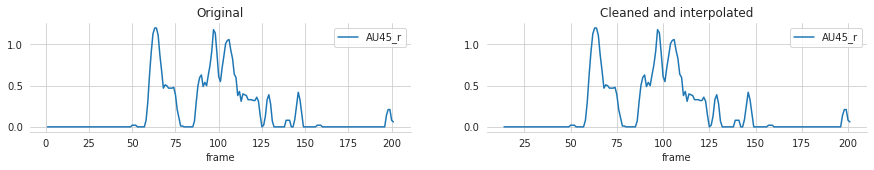

In [85]:
df_example_cleaned = df[df['filename'] == filenames_to_keep.iloc[0]]

for au in AU_COLS:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title("Original")
    axes[1].set_title("Cleaned and interpolated")

    df_example.plot(x = 'frame', y = au, ax=axes[0], figsize=(15, 2))
    df_example_cleaned.plot(x = 'frame', y = au, ax=axes[1], figsize=(15, 2))

# Normalize training set

Merge on filename index... Merge with metadata afterwards...

A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

In [106]:
df.reset_index(drop = True, inplace=True)

In [111]:
from sklearn import preprocessing

# get the metadata from original dataframe

df_metadata = df[['filename', "frame", "video_id", "emotion_1_id"]]

print(df_metadata.shape)

# get only features
X = df.drop(columns=['filename', "frame", "video_id", "emotion_1", "emotion_1_id", "confidence", "success"])
# check for null values
print(np.isnan(np.sum(X)))


min_max_scaler = preprocessing.MinMaxScaler()

# Fit and transform features
X_scaled = min_max_scaler.fit_transform(X)

# check for null values
print(np.isnan(np.sum(X_scaled)))


# Create a dataframe from normalized features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())
print(X_scaled_df.isna().sum().sum())

print(X_scaled_df.shape)


# join back on index with filename dataframe
X_scaled_df = df_metadata.join(X_scaled_df)
print(X_scaled_df.isna().sum().sum())


(2238019, 4)
AU01_r    False
AU02_r    False
AU04_r    False
AU05_r    False
AU06_r    False
AU07_r    False
AU09_r    False
AU10_r    False
AU12_r    False
AU14_r    False
AU15_r    False
AU17_r    False
AU20_r    False
AU23_r    False
AU25_r    False
AU26_r    False
AU45_r    False
dtype: bool
False
0
(2238019, 17)
0


In [100]:
df_metadata

,filename,frame,video_id,emotion_1_id
0,A050121-R_awe_p_3,1,A050121-R,18
1,A050121-R_awe_p_3,2,A050121-R,18
2,A050121-R_awe_p_3,3,A050121-R,18
3,A050121-R_awe_p_3,4,A050121-R,18
4,A050121-R_awe_p_3,5,A050121-R,18
...,...,...,...,...
2266563,A91_sad_p_3,196,A91,6
2266564,A91_sad_p_3,197,A91,6
2266565,A91_sad_p_3,198,A91,6
2266566,A91_sad_p_3,199,A91,6


In [112]:
X_scaled_df

,filename,frame,video_id,emotion_1_id,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A050121-R_awe_p_3,1,A050121-R,18,0.000,0.000,0.146,0.000000,0.345455,0.174,...,0.250,0.322,0.010,0.000,0.372,0.008,0.046,0.000,0.306,0.058
1,A050121-R_awe_p_3,2,A050121-R,18,0.000,0.000,0.132,0.000000,0.343434,0.192,...,0.254,0.308,0.014,0.000,0.336,0.006,0.046,0.000,0.282,0.026
2,A050121-R_awe_p_3,3,A050121-R,18,0.000,0.000,0.126,0.000000,0.351515,0.206,...,0.264,0.304,0.016,0.000,0.314,0.006,0.040,0.000,0.264,0.008
3,A050121-R_awe_p_3,4,A050121-R,18,0.000,0.000,0.126,0.000000,0.361616,0.222,...,0.266,0.302,0.020,0.000,0.314,0.002,0.034,0.000,0.266,0.046
4,A050121-R_awe_p_3,5,A050121-R,18,0.000,0.000,0.138,0.000000,0.381818,0.274,...,0.266,0.306,0.020,0.008,0.318,0.002,0.022,0.000,0.282,0.134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238014,A91_sad_p_3,196,A91,6,0.008,0.000,0.000,0.004435,0.000000,0.000,...,0.128,0.142,0.000,0.000,0.000,0.000,0.000,0.328,0.000,0.006
2238015,A91_sad_p_3,197,A91,6,0.000,0.000,0.000,0.000000,0.000000,0.000,...,0.114,0.134,0.000,0.008,0.004,0.000,0.000,0.308,0.000,0.008
2238016,A91_sad_p_3,198,A91,6,0.000,0.002,0.000,0.000000,0.000000,0.000,...,0.100,0.128,0.000,0.020,0.004,0.000,0.000,0.288,0.000,0.004
2238017,A91_sad_p_3,199,A91,6,0.000,0.020,0.000,0.000000,0.000000,0.000,...,0.100,0.128,0.000,0.034,0.010,0.000,0.000,0.276,0.000,0.004


In [113]:
save_path = os.path.join(output_path, 'video_data_time_series.csv')
X_scaled_df.to_csv(save_path, index=None, header=True)